In [75]:
import pandas as pd
import numpy as np
import wget
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error 
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# !python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [3]:
data = pd.read_csv('housing.csv')

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## data preprocessing

In [5]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)

for c in categorical_columns:
    data[c] = data[c].str.lower().str.replace(' ', '_')

In [6]:
data.columns[data.isna().any()].tolist()

['total_bedrooms']

In [7]:
data["total_bedrooms"] = data["total_bedrooms"].fillna(0)

In [8]:
data.columns[data.isna().any()].tolist()

[]

In [9]:
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

In [10]:
# Q1
data.mode()["ocean_proximity"]

0    <1h_ocean
1          NaN
Name: ocean_proximity, dtype: object

In [11]:
numerical_columns = [col for col in data.columns if col != "ocean_proximity"]
numerical_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [12]:
filtered_data = data[numerical_columns]

In [13]:
corr_matrix = filtered_data.corr()

In [14]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924664,-0.108197,0.044568,0.068082,0.099773,0.055310,-0.015176,-0.045967,-0.027540,0.084836,0.002476
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.065318,-0.108785,-0.071035,-0.079809,-0.144160,0.106389,-0.104112,0.002366
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.317063,-0.296244,-0.302916,-0.119034,0.105623,-0.153277,0.125396,0.013191
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.920196,0.857126,0.918484,0.198050,0.134153,0.133798,-0.174583,-0.024581
total_bedrooms,0.068082,-0.065318,-0.317063,0.920196,1.000000,0.866266,0.966507,-0.007295,0.049148,0.002717,0.122205,-0.028019
population,0.099773,-0.108785,-0.296244,0.857126,0.866266,1.000000,0.907222,0.004834,-0.024650,-0.072213,0.031397,0.069863
households,0.055310,-0.071035,-0.302916,0.918484,0.966507,0.907222,1.000000,0.013033,0.065843,-0.080598,0.059818,-0.027309
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007295,0.004834,0.013033,1.000000,0.688075,0.326895,-0.573836,0.018766
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049148,-0.024650,0.065843,0.688075,1.000000,0.151948,-0.238759,-0.023737
rooms_per_household,-0.027540,0.106389,-0.153277,0.133798,0.002717,-0.072213,-0.080598,0.326895,0.151948,1.000000,-0.387465,-0.004852


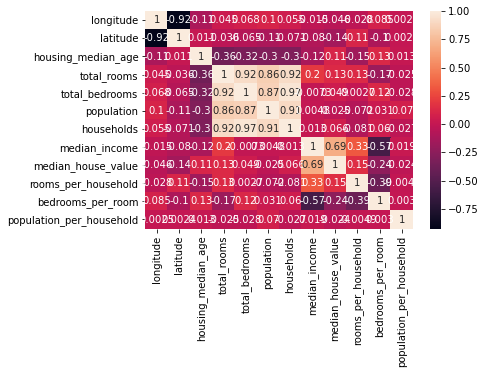

In [15]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [16]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [17]:
# Q2
print(get_top_abs_correlations(filtered_data, 5))

total_bedrooms  households        0.966507
longitude       latitude          0.924664
total_rooms     total_bedrooms    0.920196
                households        0.918484
population      households        0.907222
dtype: float64


In [18]:
mean_median_house_value = data["median_house_value"].mean()

In [19]:
data["above_average"] = data["median_house_value"].apply(lambda x: 1 if x > mean_median_house_value else 0)

In [20]:
data.head(7)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,above_average
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay,6.984127,0.146591,2.555556,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay,6.238137,0.155797,2.109842,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay,8.288136,0.129516,2.802260,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay,5.817352,0.184458,2.547945,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay,6.281853,0.172096,2.181467,1
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,near_bay,4.761658,0.231774,2.139896,1
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,near_bay,4.931907,0.192899,2.128405,1


In [21]:
data[data["above_average"] == 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,above_average
13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,near_bay,4.000000,0.274425,1.982759,0
14,-122.26,37.85,52.0,2643.0,626.0,1212.0,620.0,1.9167,159200.0,near_bay,4.262903,0.236852,1.954839,0
15,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,near_bay,4.242424,0.252679,2.640152,0
16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,near_bay,5.939577,0.176501,2.395770,0
17,-122.27,37.85,52.0,1228.0,293.0,648.0,303.0,2.1202,155500.0,near_bay,4.052805,0.238599,2.138614,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,inland,5.045455,0.224625,2.560606,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,inland,6.114035,0.215208,3.122807,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,inland,5.205543,0.215173,2.325635,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,inland,5.329513,0.219892,2.123209,0


## spliting dataset

In [22]:
df = data.drop(columns=["median_house_value"], axis=1)

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [24]:
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [26]:
# Q3
round(mutual_info_score(df_full_train.above_average, df_full_train.ocean_proximity), 2)

0.1

In [27]:
if "median_house_value" in numerical_columns:
    numerical_columns.remove('median_house_value') 
numerical_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [28]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [29]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

In [30]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [31]:
model.intercept_[0]

-0.06226206219069978

In [32]:
y_pred = model.predict(X_val)

In [33]:
predictions = (y_pred >= 0.5)

In [56]:
(y_val == predictions).mean()

0.8359980620155039

In [34]:
# Q4
round((y_val == predictions).mean(), 2)

0.84

In [57]:
# dropping feature columns in interative process:

def iterate_models(df, skip_column_name):
    
    print("Dropping column:", skip_column_name)
    df = df.drop(columns=[skip_column_name], axis=1)
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    y_test = df_test.above_average.values

    del df_train['above_average']
    del df_val['above_average']
    del df_test['above_average']
    
    numerical_columns = [col for col in df.columns if col != "ocean_proximity"]
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    
    if "median_house_value" in numerical_columns:
        numerical_columns.remove('median_house_value') 
        
    if "above_average" in numerical_columns:
        numerical_columns.remove('above_average')

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = round(accuracy_score(y_pred, y_val), 2)
    print("Accuracy:", score)
    print("Difference", abs(accuracy_score(y_pred, y_val)-0.8359980620155039))
    print()

In [58]:
req_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household']

In [59]:
# Q5
for cols in req_cols:
    iterate_models(copy.deepcopy(data), cols)

Dropping column: longitude
Accuracy: 0.83
Difference 0.004118217054263518

Dropping column: latitude
Accuracy: 0.83
Difference 0.003633720930232509

Dropping column: housing_median_age
Accuracy: 0.83
Difference 0.0043604651162790775

Dropping column: total_rooms
Accuracy: 0.84
Difference 0.00024224806201555982

Dropping column: total_bedrooms
Accuracy: 0.84
Difference 0.001211240310077577

Dropping column: population
Accuracy: 0.83
Difference 0.009689922480620172

Dropping column: households
Accuracy: 0.83
Difference 0.0019379844961240345

Dropping column: median_income
Accuracy: 0.79
Difference 0.050629844961240345

Dropping column: median_house_value
Accuracy: 0.84
Difference 0.0

Dropping column: ocean_proximity
Accuracy: 0.82
Difference 0.015746124031007724

Dropping column: rooms_per_household
Accuracy: 0.84
Difference 0.0007267441860464574

Dropping column: bedrooms_per_room
Accuracy: 0.84
Difference 0.00024224806201555982

Dropping column: population_per_household
Accuracy: 0.84

In [60]:
aplha_values_list = [0, 0.01, 0.1, 1, 10]

In [78]:
complete_data = copy.deepcopy(data.drop(columns=["above_average"], axis=1))

In [79]:
# applying log transform
complete_data["median_house_value_log_transformed"] = np.log10(complete_data["median_house_value"])

In [80]:
data_for_training = complete_data.drop(columns=["median_house_value"], axis=1)

In [81]:
df_full_train, df_test = train_test_split(data_for_training, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [82]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value_log_transformed.values
y_val = df_val.median_house_value_log_transformed.values
y_test = df_test.median_house_value_log_transformed.values

del df_train['median_house_value_log_transformed']
del df_val['median_house_value_log_transformed']
del df_test['median_house_value_log_transformed']

In [83]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [85]:
# Q6
for aplha_val in aplha_values_list:
    print("For alpha value:", aplha_val)
    model = Ridge(alpha=aplha_val, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rms = mean_squared_error(y_pred, y_val, squared=False)
    print("RMSE rounded:", round(rms, 3))
    print("RMSE (un)rounded:", rms)
    print()

For alpha value: 0
RMSE rounded: 0.228
RMSE (un)rounded: 0.22759947575193273

For alpha value: 0.01
RMSE rounded: 0.228
RMSE (un)rounded: 0.22759947575936526

For alpha value: 0.1
RMSE rounded: 0.228
RMSE (un)rounded: 0.22759947582997314

For alpha value: 1
RMSE rounded: 0.228
RMSE (un)rounded: 0.22759947653976415

For alpha value: 10
RMSE rounded: 0.228
RMSE (un)rounded: 0.22759948362651972

